In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from scipy.spatial import cKDTree
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import root

In [2]:
#Cargar datos
LABELS = ["Alt_Si3N4", "Anc_Si3N4", "lambda", "n_eff", "A_eff"]

def load_and_normalize(fname):
    with h5py.File(fname, "r") as f:
        A = f["/A"][...]
    axis5 = next((ax for ax, s in enumerate(A.shape) if s == 5), None)
    if axis5 is None:
        raise ValueError(f"No encontré eje de tamaño 5 en {fname}")
    if axis5 != A.ndim - 1:
        A = np.moveaxis(A, axis5, -1)
    return A

def to_dataframe(arr):
    nA, nB, nC, _ = arr.shape
    ii, jj, kk = np.indices((nA, nB, nC))
    flat = np.column_stack([ii.ravel()+1, jj.ravel()+1, kk.ravel()+1, arr.reshape(-1, arr.shape[-1])])
    df = pd.DataFrame(flat, columns=["i","j","k","Alt_Si3N4","Anc_Si3N4","lambda","n_eff","A_eff"])
    return df

In [3]:
archivos = [
    "Datos_reto/Datos12.h5",
    "Datos_reto/Datos13.h5"
]
datasets = [load_and_normalize(fname) for fname in archivos]

def check_borders(d1, d2):
    alt1_end = np.round(d1[-1,0,0,0],6)
    alt2_start = np.round(d2[0,0,0,0],6)
    anc1_end = np.round(d1[0,-1,0,1],6)
    anc2_start = np.round(d2[0,0,0,1],6)
    print(f"Check Alt: {alt1_end} vs {alt2_start}, Check Anc: {anc1_end} vs {anc2_start}")
    if not np.isclose(alt1_end, alt2_start) and not np.isclose(anc1_end, anc2_start):
        print("⚠️ Advertencia: los bordes no coinciden perfectamente")

for i in range(len(datasets)-1):
    check_borders(datasets[i], datasets[i+1])

#DatosU = np.concatenate(datasets, axis=0)

#with h5py.File("Datos_reto/DatosU.h5", "w") as f_out:
#    f_out.create_dataset("A", data=DatosU)

#print("✅ Dataset unificado guardado en DatosU.h5, shape:", DatosU.shape)

def to_dataframe(arr):
    nA, nB, nC, _ = arr.shape
    rows = []
    for ii in range(nA):
        for jj in range(nB):
            for kk in range(nC):
                rec = {"i": ii+1, "j": jj+1, "k": kk+1}
                for p, name in enumerate(LABELS):
                    rec[name] = arr[ii, jj, kk, p]
                rows.append(rec)
    return pd.DataFrame(rows, columns=["i","j","k"]+LABELS)

dfs = [to_dataframe(A) for A in datasets]
df = pd.concat(dfs, ignore_index=True)

#df = to_dataframe(DatosU)

df = df[df['n_eff'] != 0]
df["lambda_nm"] = df["lambda"] * 1000 
print(df)

df.to_csv('Datos_reto/DatosU.csv', index=False)

Check Alt: 0.4 vs 0.4, Check Anc: 1.17 vs 0.6
       i  j  k  Alt_Si3N4  Anc_Si3N4  lambda     n_eff         A_eff  \
0      1  1  1   0.400000       0.60    0.50  1.960858  1.505415e-13   
1      1  1  2   0.416667       0.60    0.50  1.964923  1.552818e-13   
2      1  1  3   0.433333       0.60    0.50  1.968701  1.601730e-13   
3      1  1  4   0.450000       0.60    0.50  1.972013  1.649021e-13   
4      1  1  5   0.466667       0.60    0.50  1.974902  1.695158e-13   
...   .. .. ..        ...        ...     ...       ...           ...   
4895  50  7  3   0.433333       1.17    1.57  1.620221  7.216298e-13   
4896  50  7  4   0.450000       1.17    1.57  1.630580  7.203339e-13   
4897  50  7  5   0.466667       1.17    1.57  1.640663  7.207191e-13   
4898  50  7  6   0.483333       1.17    1.57  1.650414  7.219034e-13   
4899  50  7  7   0.500000       1.17    1.57  1.659392  7.237411e-13   

      lambda_nm  
0         500.0  
1         500.0  
2         500.0  
3         500.0  

In [4]:
c = 2.9979e8      #m/s

pg = 30

intersecciones = []

def neff(lam, p):
    return np.polyval(p, lam)               #el neff no debe tener unidades

def neff_p(lam, dp):
    return np.polyval(dp, lam)              #tiene unidades de 1/la unida que le entre en mi caso 1/um

def k(lam, p):
    return (2*np.pi/lam) * neff(lam, p)         #tiene unidaes de lo que le entre, en este caso de 1/um

def k_prime(lam, p, dp):
    return (1/c)*(neff(lam, p) - lam*(neff_p(lam, dp)))             #tiene unidades de s/m por que lo que esta en parentesis no tiene unidaes

def k_prime_omega(omega, p, dp):
    lam = (2*np.pi*c / omega) * 1e6
    return (1/c)*(neff(lam, p) - lam*(neff_p(lam, dp)))

def k_of_omega(om, p):
    lam_um = (2*np.pi*c / om) * 1e6
    neff = np.polyval(p, lam_um)
    return (2*np.pi/lam_um)*neff * 1e6

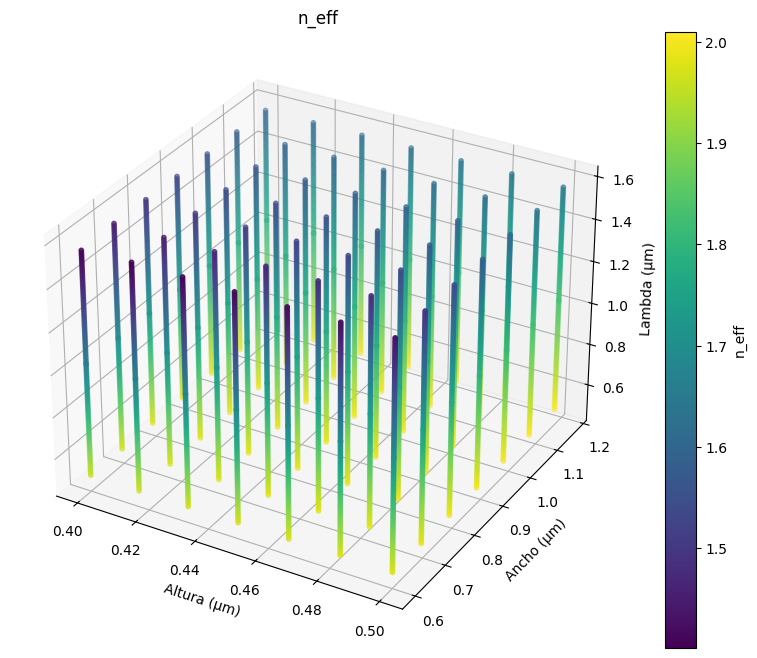

In [5]:
#Grafica N_efectivo
fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(111, projection='3d')
p1 = ax1.scatter(df["Alt_Si3N4"], df["Anc_Si3N4"], df["lambda"],
                 c=df["n_eff"], cmap="viridis", s=10)
ax1.set_xlabel("Altura (µm)")
ax1.set_ylabel("Ancho (µm)")
ax1.set_zlabel("Lambda (µm)")
fig1.colorbar(p1, ax=ax1, label="n_eff")
ax1.set_title("n_eff")


plt.show()

In [6]:
#intento con una geometria aleatoria hacer el grafico de ts = -ti

jpn = 3       #Ancho 2
kpn = 3       #Alto 1

df_p = df[(df['j']==jpn) & (df['k']==kpn)]

lam_p = df_p['lambda'].values
neff_vals = df_p['n_eff'].values

alto = df_p['Alt_Si3N4'].iloc[0]
ancho = df_p['Anc_Si3N4'].iloc[0]

print(f"Geometría seleccionada: j={jpn}, k={kpn}")
print(f"Altura = {alto:.4f} µm")
print(f"Ancho  = {ancho:.4f} µm")

Geometría seleccionada: j=3, k=3
Altura = 0.4333 µm
Ancho  = 0.7900 µm


In [7]:
def neffvlambda(df, grado=30):
    if len(df) <= grado:
        raise ValueError("No hay suficientes puntos para ajuste polinomial.")

    x = df["lambda"].values
    y = df["n_eff"].values

    coef = np.polyfit(x, y, grado)
    p = np.poly1d(coef)
    return p

C:\Users\david\AppData\Local\Temp\ipykernel_24464\3842076212.py:8: RankWarning: Polyfit may be poorly conditioned
  coef = np.polyfit(x, y, grado)
C:\Users\david\AppData\Local\Temp\ipykernel_24464\51248466.py:65: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  if len(CS.collections)==0:
C:\Users\david\AppData\Local\Temp\ipykernel_24464\51248466.py:67: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for col in CS.collections:


[[0.82302679 0.55875591]
 [0.82302623 1.56168141]]


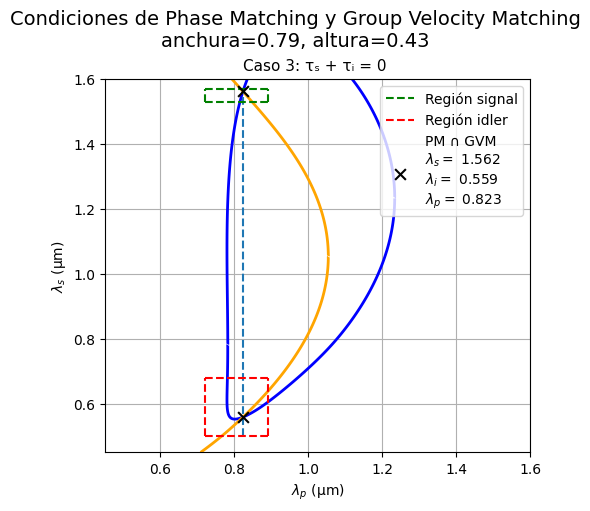

In [8]:
p = neffvlambda(df_p, pg)           #no tiene unidades
dp = np.polyder(p)                  #unidades de 1/um

Ns = 2**10

delta = 1e-3

Lamp = np.linspace(0.45, 1.6, Ns)
Lams = np.linspace(0.45, 1.6, Ns)
LAMP, LAMS = np.meshgrid(Lamp, Lams)

LAMI = 1/((2/LAMP)-(1/LAMS))

mask = np.isfinite(LAMI) & (LAMI > 0)

kp = k(LAMP, p)
ks = k(LAMS, p)
ki = np.full_like(ks, np.nan)
ki[mask] = k(LAMI[mask], p)

Dk = 2*kp - ks - ki

Taus = np.full_like(kp, np.nan)
Taui = np.full_like(kp, np.nan)

Taus[mask] = (k_prime(LAMP[mask], p, dp) - k_prime(LAMS[mask], p, dp))            #s/m
Taui[mask] = (k_prime(LAMP[mask], p, dp) - k_prime(LAMI[mask], p, dp))            #s/m

eps_dk  = 1e-4 * np.nanmedian(np.abs(Dk))   # o un percentil
eps_tau = 1e-6 * np.nanmedian(np.abs(Taus+Taui))

sTau = Taui + Taus          #s/m

mask1 = (np.abs(sTau) <= eps_tau) & (np.isfinite(sTau))
mask2 = (np.abs(Dk) <= eps_dk) & (np.isfinite(Dk))
mask3 = Taui*Taus < 0

maskf = mask1 & mask2 & mask3

band = np.abs(LAMP - LAMS) < delta
valid = maskf & ~band

DK_f  = np.where(mask & ~band, Dk,   np.nan)
TAU_f = np.where(mask & ~band, sTau, np.nan)

def find_pm_gvm_intersections(lamp, lams, DK, TAU,
                              prox_pixels=1.0,        # vecindad para candidatos
                              tol_root=1e-12,         # tolerancia del solver
                              max_iter=50,            # iteraciones máximas
                              dedup_tol=1e-4):        # fusión de duplicados (µm)

    # 0) Interpoladores bilineales (permiten enmascarados NaN)
    f_DK  = RegularGridInterpolator((lams, lamp), DK,  bounds_error=False, fill_value=np.nan)
    f_TAU = RegularGridInterpolator((lams, lamp), TAU, bounds_error=False, fill_value=np.nan)

    # 1) Contornos (no se muestran)
    fig, ax = plt.subplots()
    CS1 = ax.contour(lamp, lams, DK,  levels=[0], colors='none')
    CS2 = ax.contour(lamp, lams, TAU, levels=[0], colors='none')
    plt.close(fig)

    # Extraer vértices de TODOS los path de cada contorno
    def collect_vertices(CS):
        verts = []
        if len(CS.collections)==0: 
            return np.empty((0,2))
        for col in CS.collections:
            for pth in col.get_paths():
                v = pth.vertices
                if v.size:
                    verts.append(v)
        return np.vstack(verts) if verts else np.empty((0,2))

    V1 = collect_vertices(CS1)  # puntos sobre Δk=0
    V2 = collect_vertices(CS2)  # puntos sobre TAU=0
    if V1.size==0 or V2.size==0:
        return np.empty((0,2))

    # 2) Candidatos por proximidad
    # Escala de pixel ~ paso máximo en ejes
    dλp = np.min(np.diff(lamp))
    dλs = np.min(np.diff(lams))
    pixel = max(dλp, dλs)
    tree = cKDTree(V2)
    idx_near = tree.query_ball_point(V1, r=prox_pixels*pixel)  # lista de listas

    seeds = []
    for i, lst in enumerate(idx_near):
        if not lst: 
            continue
        # semilla: punto de Δk=0 y su vecino más cercano de TAU=0
        p1 = V1[i]
        # escoge el más cercano para estabilizar la raíz
        d, j = tree.query(p1)
        p0 = 0.5*(p1 + V2[j])  # punto medio como mejor inicial
        seeds.append(p0)

    if not seeds:
        return np.empty((0,2))
    seeds = np.array(seeds)

    # 3) Refinamiento por raíz 2D
    def F(xy):
        λs, λp = xy[1], xy[0]  # cuidado: interpoladores reciben (λs, λp)
        val = np.array([f_DK((λs, λp)), f_TAU((λs, λp))])
        return val

    sols = []
    for p0 in seeds:
        sol = root(F, x0=p0, method='hybr', tol=tol_root, options={'maxfev': max_iter})
        if sol.success and np.all(np.isfinite(sol.x)):
            λp, λs = sol.x
            # descarta puntos fuera de dominio o donde alguna función no esté bien definida
            if (lamp.min()<=λp<=lamp.max()) and (lams.min()<=λs<=lams.max()):
                vals = F(sol.x)
                if np.all(np.isfinite(vals)) and np.linalg.norm(vals, ord=np.inf) < 5e-6:
                    sols.append([λp, λs])

    if not sols:
        return np.empty((0,2))
    sols = np.array(sols)

    # 4) Quitar duplicados cercanos
    keep = []
    used = np.zeros(len(sols), dtype=bool)
    for i in range(len(sols)):
        if used[i]: 
            continue
        close = np.linalg.norm(sols - sols[i], axis=1) < dedup_tol
        used[close] = True
        keep.append(sols[i])
    return np.array(keep)


pts = find_pm_gvm_intersections(Lamp, Lams, DK_f, TAU_f)
if pts.size == 0:
    print("No hay intersecciones")
else:
    # filtra puntos casi en la diagonal λp≈λs (degenerados)
    delta = 1e-3  # µm
    mask = ~np.isclose(pts[:,0], pts[:,1], atol=delta)
    pts2 = pts[mask]

print(pts2)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True,
                                     constrained_layout=True)
titles = ["Caso 3: τₛ + τᵢ = 0 "]
colors = ['orange']
taus_list = [Taui + Taus]

vmax = np.nanpercentile(np.abs(Dk), 99)
vmin = -vmax

# Contorno Δk = 0
plt.contour(LAMP, LAMS, DK_f, levels=[0], colors='b', linewidths=2)
# Contorno τ = 0
plt.contour(LAMP, LAMS, TAU_f, levels=[0], colors=colors[0], linewidths=2)
plt.vlines(pts2[:,0][0], 0.5, 1.57, linestyles='dashed')
plt.vlines(0.72,1.53,1.57, color='green', linestyle='dashed', label='Región signal')
plt.vlines(0.89,1.53,1.57, color='green', linestyle='dashed')
plt.vlines(0.72,0.50,0.68, color='red', linestyle='dashed', label='Región idler')
plt.vlines(0.89,0.50,0.68, color='red', linestyle='dashed')
plt.hlines(1.53,0.72,0.89, color='green', linestyle='dashed')
plt.hlines(1.57,0.72,0.89, color='green', linestyle='dashed')
plt.hlines(0.50,0.72,0.89, color='red', linestyle='dashed')
plt.hlines(0.68,0.72,0.89, color='red', linestyle='dashed')

axes.set_title(titles[0], fontsize=11)
axes.set_xlabel(r'$\lambda_p$ (µm)')
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))

if len(pts2):
    plt.scatter(pts2[:,0], pts2[:,1], s=60, c='k', marker='x', zorder=5, label=f'PM ∩ GVM \n' r'$\lambda_s =$ ' + f'{pts2[:,1][1]:.4} \n'+ r'$\lambda_i =$ '+f'{pts2[:,1][0]:.3} \n'+r'$\lambda_p =$ '+f'{pts2[:,0][0]:.3}')

axes.set_ylabel(r'$\lambda_s$ (µm)')
plt.suptitle(f"Condiciones de Phase Matching y Group Velocity Matching\nanchura={df.loc[(df['j'] == jpn) & (df['k'] == kpn), 'Anc_Si3N4'].iloc[0]:.2f}, altura={df.loc[(df['j'] == jpn) & (df['k'] == kpn), 'Alt_Si3N4'].iloc[0]:.2f}",
fontsize=14)
plt.grid()
plt.legend()
plt.show()

idler singal pump
0.5587559138015836 1.5616814145702331 0.8230267862098675
2omp - (oms0+omi0) = 5.438e+10 rad/s
σ_opt = 6.232e+10 rad/s
1.2061590191605986 3.3711251670228495


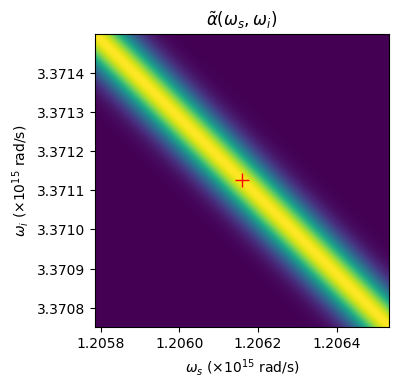

In [9]:
# === Parámetros físicos ===
Gamma = 0.193             # aproximación sinc -> gauss
L = 0.5

# --- Punto de operación (en µm) ya definido por ti ---
lambda_p_op, lambda_s_op, lambda_i_op = pts2[:,0][0], pts2[:,1][1], pts2[:,1][0]
print('idler', 'singal', 'pump')
print(lambda_i_op, lambda_s_op, lambda_p_op)

#lambda_p_opm, lam_s_axism, lambda_i_opm = lambda_p_op*1e6

tau_s = L*(k_prime(lambda_p_op, p, dp) - k_prime(lambda_s_op, p, dp))           #s
tau_i = L*(k_prime(lambda_p_op, p, dp) - k_prime(lambda_i_op, p, dp))           #s

# Pasar a frecuencias angulares
omega_p = 2*np.pi*c / (lambda_p_op*1e-6)
omega_s0 = 2*np.pi*c / (lambda_s_op*1e-6)
omega_i0 = 2*np.pi*c / (lambda_i_op*1e-6)

# Comprobar centrado
delta_E = (omega_s0 + omega_i0) - 2*omega_p
print(f"2omp - (oms0+omi0) = {-delta_E:.3e} rad/s")

# === Condición de factorabilidad: 1/σ^2 = -(Γ L^2 / 4) τs τi ===
prod = tau_s * tau_i  # tau_s,tau_i en [s]
if prod >= 0:
    raise ValueError("No se puede factorar con σ real porque τs·τi ≥ 0 en este punto. Cambia geometría o punto.")
sigma_opt = np.sqrt(-2.0/(Gamma*prod))    # [rad/s]

print(f"σ_opt = {sigma_opt:.3e} rad/s")

# === Malla alrededor del punto de operación (elige el tamaño que prefieras) ===
# ancho en múltiplos de σ para visualizar
mul = 6.0
omega_s_grid = np.linspace((omega_s0 - mul*sigma_opt), (omega_s0 + mul*sigma_opt), Ns)
omega_i_grid = np.linspace((omega_i0 - mul*sigma_opt), (omega_i0 + mul*sigma_opt), Ns)
omS, omI = np.meshgrid(omega_s_grid, omega_i_grid, indexing='xy')

# === Envolvente de bomba acoplada (anti-diagonal): α̃(oms,omi) ===
# forma estándar: depende de (oms + omi - 2omp)
alpha_tilde = np.exp(-((omS - omega_s0 + omI - omega_i0)**2)/(2*sigma_opt**2))

# --- Escala para ejes en 10^15 rad/s ---
scl = 1e-15
oms_plot = omega_s_grid * scl
omi_plot = omega_i_grid * scl
oms0_plot = omega_s0 * scl
omi0_plot = omega_i0 * scl
print(omega_s0*scl, omega_i0*scl)

plt.figure(figsize=(3.8,3.8))
plt.imshow(
    alpha_tilde,
    extent=[oms_plot.min(), oms_plot.max(), omi_plot.min(), omi_plot.max()],
    origin='lower', aspect='auto', cmap='viridis', vmin=0, vmax=1)
plt.plot([oms0_plot], [omi0_plot], 'r+', ms=10)
plt.xlabel(r'$\omega_s$ ($\times 10^{15}$ rad/s)')
plt.ylabel(r'$\omega_i$ ($\times 10^{15}$ rad/s)')
plt.title(r'$\tilde{\alpha}(\omega_s,\omega_i)$')
plt.show()

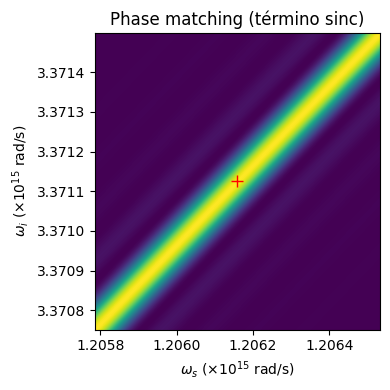

In [10]:
# --- Δk(oms, omi) y término de phase-matching (sinc) ---
Ldelk = tau_s*(omS - omega_s0) + tau_i*(omI - omega_i0)

x = Ldelk/2

#sinc[(L/2)Δk] con L en µm; np.sinc(x) = sin(πx)/(πx)
PM = np.sinc(x/np.pi)*np.exp(1j*x)
PM2 = np.abs(PM)**2                  

PM3 = np.abs(PM*alpha_tilde)**2             #aproximacion a primer orden
#Graficar en om (×10^15)
scl = 1e-15
oms_plot = omega_s_grid * scl
omi_plot = omega_i_grid * scl
oms0_plot, omi0_plot = omega_s0*scl, omega_i0*scl

plt.figure(figsize=(4.0,4.0))
im = plt.imshow(PM2, extent=[oms_plot.min(), oms_plot.max(),
                             omi_plot.min(), omi_plot.max()],
                origin='lower', cmap='viridis', aspect='auto',
                vmin=0, vmax=1)

plt.plot([oms0_plot], [omi0_plot], 'r+', ms=9)
plt.xlabel(r'$\omega_s$ ($\times 10^{15}$ rad/s)')
plt.ylabel(r'$\omega_i$ ($\times 10^{15}$ rad/s)')
plt.title('Phase matching (término sinc)')
plt.tight_layout()
plt.show()


In [11]:
def compute_jsa(p,
                lam_p0_um, lam_s0_um, lam_i0_um,   # punto de operación (µm)
                L_m,                                # longitud (m)
                sigma_omega=None,                   # σ de la bomba (rad/s), opcional
                Gamma=0.193, tau_s=None, tau_i=None,# para fijar σ vía factorabilidad
                Ns=2**8, Ni=None, Nw=801, m=4):
    """
    Devuelve: (omega_s_grid, omega_i_grid, JSA(compleja), JSI)
    """
    if Ni is None:
        Ni = Ns

    # centros en omega
    omega_p  = 2*np.pi*c / (lam_p0_um*1e-6)
    omega_s0 = 2*np.pi*c / (lam_s0_um*1e-6)
    omega_i0 = 2*np.pi*c / (lam_i0_um*1e-6)

    # mallas omega_s, omega_i (± m*sigma_omega)
    omega_s_grid = np.linspace(omega_s0 - m*sigma_omega, omega_s0 + m*sigma_omega, Ns)
    omega_i_grid = np.linspace(omega_i0 - m*sigma_omega, omega_i0 + m*sigma_omega, Ni)
    OMEGA_S, OMEGA_I = np.meshgrid(omega_s_grid, omega_i_grid, indexing='xy')  # (Ni, Ns)

    # eje de integración omega (alrededor de omega_p)
    omega_int = np.linspace(omega_p - m*sigma_omega, omega_p + m*sigma_omega, Nw)  # (Nw,)
    domega = omega_int[1] - omega_int[0]
    
    alpha_omega  = np.exp(-0.5*((omega_int - omega_p)/sigma_omega)**2)                 # (Nw,)
    omega_prime  = (OMEGA_S[None,:,:] + OMEGA_I[None,:,:]) - omega_int[:,None,None]           # (Nw,Ni,Ns)
    alpha_omega_prime = np.exp(-0.5*((omega_prime - omega_p)/sigma_omega)**2)          # (Nw,Ni,Ns)

    k_om   = k_of_omega(omega_int, p)[:, None, None]          # (Nw,1,1)
    k_om_p = k_of_omega( (OMEGA_S[None,:,:] + OMEGA_I[None,:,:]) - omega_int[:,None,None], p)  # (Nw,Ni,Ns)
    k_os   = k_of_omega(OMEGA_S, p)[None,:,:]                 # (1,Ni,Ns)
    k_oi   = k_of_omega(OMEGA_I, p)[None,:,:]                 # (1,Ni,Ns)

    delta_k = k_om + k_om_p - k_os - k_oi                     # [1/m], depende de ω
    x = 0.5 * L_m * delta_k                                   # adimensional

    PM = np.sinc(x/np.pi) * np.exp(1j*x)

    # integrando y JSA
    integrand = alpha_omega[:,None,None] * alpha_omega_prime * PM   # (Nw,Ni,Ns)
    JSA = np.trapezoid(integrand, omega_int, axis=0)                    # (Ni,Ns)
    JSI = np.abs(JSA)**2

    return omega_s_grid, omega_i_grid, JSA, JSI


Longitud calculada = 2.801e-02 m
sigma_omega = 1.112e+12 rad/s


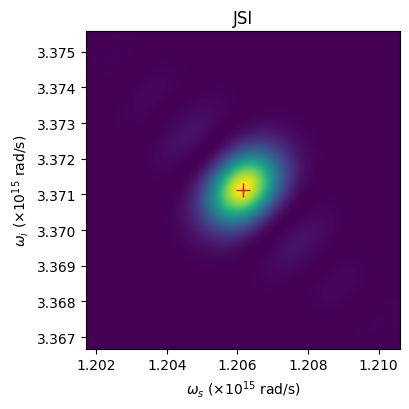

In [12]:
del_lam = 4e-10
del_ome = (2*np.pi*c / (lambda_p_op*1e-6)**2) * del_lam

Tas = k_prime(lambda_p_op, p, dp) - k_prime(lambda_s_op, p, dp)
Tai = k_prime(lambda_p_op, p, dp) - k_prime(lambda_i_op, p, dp)

LC = np.sqrt(-2.0/(del_ome**2 * Gamma * Tas * Tai))

print(f"Longitud calculada = {LC:.3e} m")

print(f"sigma_omega = {del_ome:.3e} rad/s")

omega_s_grid, omega_i_grid, JSA, JSI = compute_jsa(
    p,
    lambda_p_op, lambda_s_op, lambda_i_op,
    L_m=LC
    , sigma_omega=del_ome,
    tau_s=Tas, tau_i=Tai, m = 4
)

imax, jmax = np.unravel_index(np.nanargmax(JSI), JSI.shape)
x0 = omega_s_grid[imax]
y0 = omega_i_grid[jmax]

halfspan_x = 3*sigma_opt
halfspan_y = 3*sigma_opt

scale = 1e-15
plt.figure(figsize=(4.2,4.2))
im = plt.imshow(JSI,
                extent=[omega_s_grid.min()*scale, omega_s_grid.max()*scale,
                        omega_i_grid.min()*scale, omega_i_grid.max()*scale],
                origin='lower', cmap='viridis', aspect='auto')
plt.xlabel(r'$\omega_s$ ($\times 10^{15}$ rad/s)')
plt.ylabel(r'$\omega_i$ ($\times 10^{15}$ rad/s)')
plt.plot([omega_s0*scale], [omega_i0*scale], 'r+', ms=10)
plt.title('JSI')
plt.tight_layout()
plt.show()

In [13]:
deltaE = omega_s0 + omega_i0 - 2*omega_p

if abs(deltaE) > 1e-6*omega_p:
    print(f"no hay molleja", 1e-6*omega_p, deltaE)
else:
    print(f"que es lo que hay")


no hay molleja 2288669281.243844 -54376304240.0



-------------------------------------
Número de Schmidt K = 1.322692122987823
Coeficiente Primer Término =   0.8630148135088089
-------------------------------------


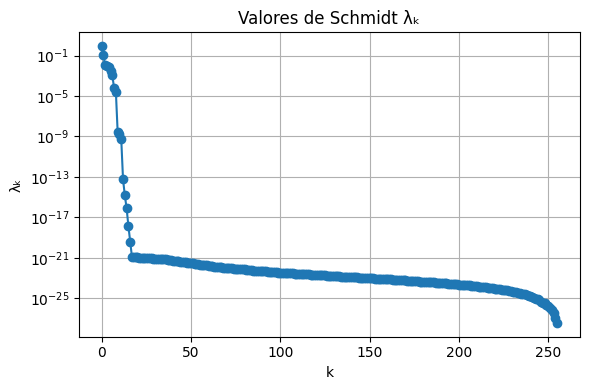

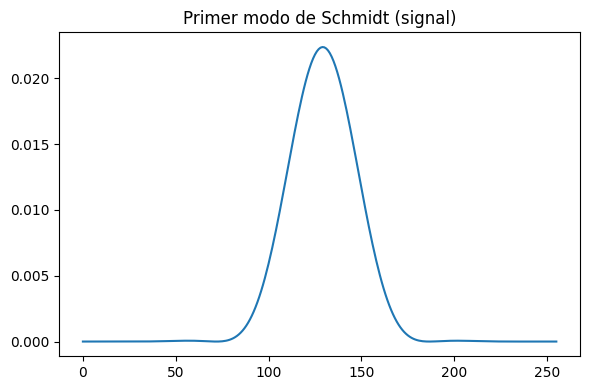

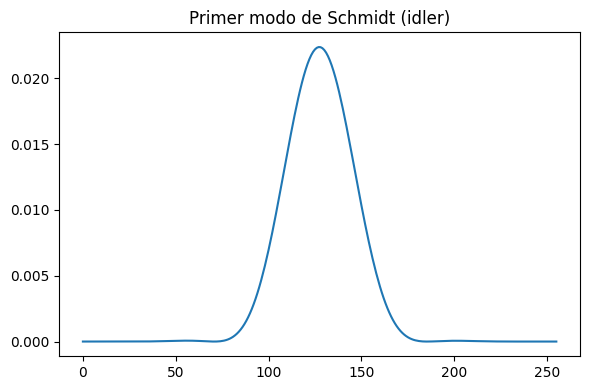

In [14]:
# NORMALIZAR LA JSA PARA SCHMIDT

JSA_full = JSA
norm_jsa = np.sqrt(np.sum(np.abs(JSA_full)**2))
JSA_norm = JSA_full / norm_jsa
# DESCOMPOSICIÓN DE SCHMIDT (SVD)
U, S, Vh = np.linalg.svd(JSA_norm, full_matrices=False)

# Valores de Schmidt
lambdas = S**2

# Modos (signal e idler)
u_modes = U
v_modes = Vh.conj().T

# Número de Schmidt
K = 1 / np.sum(lambdas**2)
print("\n-------------------------------------")
print("Número de Schmidt K =", K)
print("Coeficiente Primer Término =  ", lambdas[0])
print("-------------------------------------")

# GRAFICAR VALORES λ_k
plt.figure(figsize=(6,4))
plt.semilogy(lambdas, 'o-')
plt.title("Valores de Schmidt λₖ")
plt.xlabel("k")
plt.ylabel("λₖ")
plt.grid(True)
plt.tight_layout()
plt.show()

# GRAFICAR primeros modos
plt.figure(figsize=(6,4))
plt.plot(np.abs(u_modes[:,0])**2)
plt.title("Primer modo de Schmidt (signal)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(np.abs(v_modes[:,0])**2)
plt.title("Primer modo de Schmidt (idler)")
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

def load_h5_to_df(path_h5, dataset_name="/A"):
    with h5py.File(path_h5, "r") as f:
        A = f[dataset_name][...]

    axis5 = next((ax for ax, s in enumerate(A.shape) if s == 5), None)
    if axis5 is None:
        raise ValueError("No se encontró un eje de tamaño 5 en el dataset.")

    if axis5 != A.ndim - 1:
        A = np.moveaxis(A, axis5, -1)

    lam       = A[..., 0]   # longitud de onda (mismo orden que en archivo)
    neff_par  = A[..., 1]
    neff_impar= A[..., 2]
    ancho     = A[..., 3]
    delta_n   = A[..., 4]

    data = {
        "lambda": lam.ravel(),
        "neff_par": neff_par.ravel(),
        "neff_impar": neff_impar.ravel(),
        "ancho_guia": ancho.ravel(),
        "delta_n": delta_n.ravel(),
    }
    df = pd.DataFrame(data)

    df = df.dropna().drop_duplicates()

    return df

def plot_delta_n_vs_ancho(df, gap_fijo=0.3, lambdas_plot=None):
    if lambdas_plot is None:
        lam_unique = np.sort(df["lambda"].unique())
        if len(lam_unique) < 3:
            raise ValueError("El DF no tiene al menos 3 longitudes de onda distintas.")
        idx = np.linspace(0, len(lam_unique)-1, 3, dtype=int)
        lambdas_plot = lam_unique[idx]

    plt.figure(figsize=(6,4.2))
    for lam0 in lambdas_plot:
        df_lam = df[np.isclose(df["lambda"], lam0)]
        df_lam = df_lam.sort_values("ancho_guia")
        if df_lam.empty:
            continue
        plt.plot(df_lam["ancho_guia"], df_lam["delta_n"],
                 marker='o', linewidth=1.8, ms=4, label=f"λ = {lam0:.4f} μm")

    plt.xlabel("Ancho de guía (μm)")
    plt.ylabel("Δn = n_par - n_impar")
    plt.title(f"Δn vs. ancho — Gap fijo = {gap_fijo} μm")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

